# 230107(Sat)_주말 CNN 스터디(with 주환, 상현)

## 월간 데이콘 컴퓨터 비전 학습 경진대회 코드로 연습

### Import Library

In [1]:
# colab 관련
from google.colab import drive, files

# pandas, numpy
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 모델링
from keras import Sequential
from keras.layers import*

### Data Load

In [6]:
# 구글 드라이브 연동

In [7]:
drive.mount('cvision')

Mounted at cvision


In [8]:
train = pd.read_csv('/content/cvision/MyDrive/235626_컴퓨터 비전 학습 경진대회_data/train.csv')

In [9]:
test = pd.read_csv('/content/cvision/MyDrive/235626_컴퓨터 비전 학습 경진대회_data/test.csv')

In [10]:
sub = pd.read_csv('/content/cvision/MyDrive/235626_컴퓨터 비전 학습 경진대회_data/submission.csv')

### EDA

In [11]:
print("데이터의 형태(행,열):", train.shape)

데이터의 형태(행,열): (2048, 787)


In [12]:
train.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [55]:
# 데이터 구조 확인하기
print('train 데이터:', train.shape)
print('test 데이터:', test.shape)
print('submission 데이터:', sub.shape)

train 데이터: (2048, 787)
test 데이터: (20480, 786)
submission 데이터: (20480, 2)


### Target

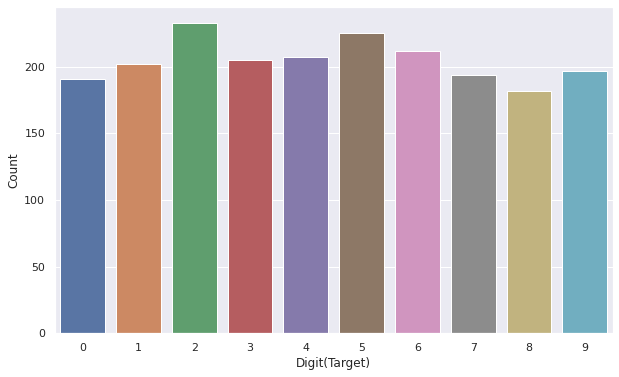

In [56]:
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="digit", data=train)
ax.set(xlabel='Digit(Target)', ylabel='Count');

### Letter

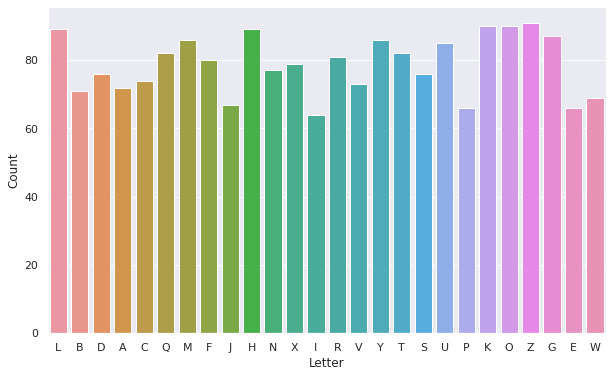

In [57]:
plt.figure(figsize=(10,6))
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="letter", data=train)
ax.set(xlabel='Letter', ylabel='Count');

### Data Preprocessing(데이터 전처리)

In [15]:
# 불필요한 column 제거
train2 = train.drop(['id','digit','letter'], 1)
test2 = test.drop(['id','letter'], 1)

<ipython-input-15-ce48a6b4bc10>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train2 = train.drop(['id','digit','letter'], 1)
<ipython-input-15-ce48a6b4bc10>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test2 = test.drop(['id','letter'], 1)


In [16]:
# 데이터프레임(pd)을 ndarray(np) 형식으로 변환 후 reshape
train2 = train2.values.reshape(-1, 28, 28, 1)
test2 = test2.values.reshape(-1, 28, 28, 1)

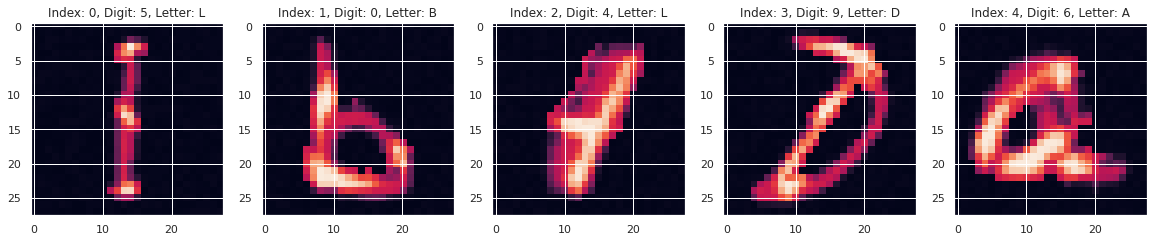

In [17]:
plt.figure(figsize = (20, 4))
for i in range(5):
  img = train2[i].reshape(28, 28)
  digit = train.loc[i, 'digit']
  letter = train.loc[i, 'letter']
  plt.subplot(1, 5, i + 1)
  plt.title('Index: %i, Digit: %s, Letter: %s'%(i, digit, letter))
  plt.imshow(img)

In [18]:
# data normalization
train2 = train2 / 255
test2 = test2 / 255

In [19]:
# 평가셋(validation) 생성
x_train, x_valid, y_train, y_valid = train_test_split(train2, train['digit'], test_size=0.2, random_state=42, stratify=train['digit'])

### 1. ImageDataGenerator로 Data Augmentation
(데이터 첨가 또는 데이터 증강은 주로 기계 학습을 위해 새로운 데이터를 첨가하거나, 수를 늘리는 기법)  
좋은점: 정칙화 기능을 하여 기계 학습 모델을 훈련할 때 과적합을 줄이는 데에 도움이 된다.

In [20]:
idg = ImageDataGenerator(rotation_range = 45)
idg2 = ImageDataGenerator()

train_generator = idg.flow(x_train, y_train)
valid_generator = idg2.flow(x_valid, y_valid)
test_generator = idg2.flow(test2, shuffle=False)

### 2. Data Augmentation 이미지 시각화

In [21]:
# import random

In [22]:
# idx = random.randint(0,2)

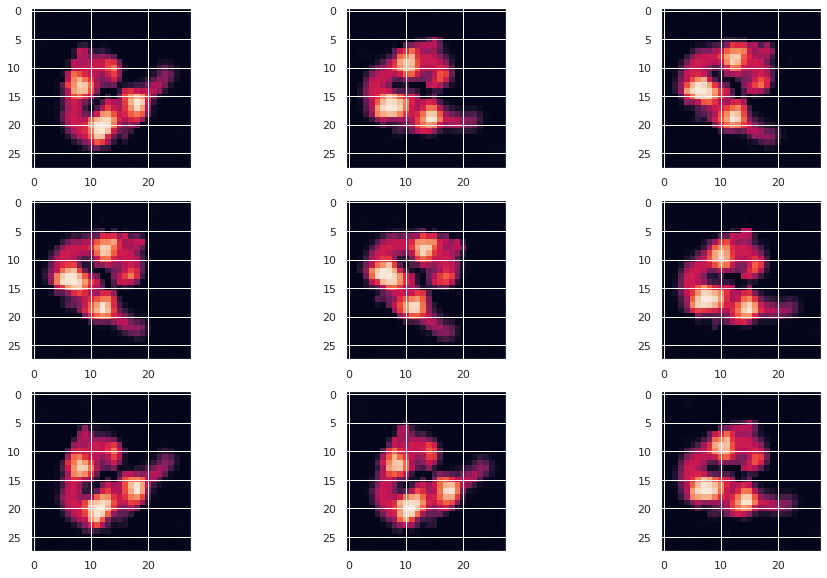

In [23]:
sample_data = train2[5].reshape(1,28,28,1)
sample_generator = idg.flow(sample_data, batch_size=1)

plt.figure(figsize=(16,10))

for i in range(9) : 
    plt.subplot(3,3,i+1)
    plt.imshow(sample_generator[0].reshape(28,28))

## Modeling

#### 3. callback 적용하기

In [24]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [25]:
reLR = ReduceLROnPlateau(patience=20, verbose=1, factor=0.5) # learning rate scheduler

In [26]:
es = EarlyStopping(patience=30, verbose=1)

In [27]:
mc = ModelCheckpoint('best_cvision.h5', save_best_only=True, verbose=1)

#### 4. Dropout
Convolutional Layer, FullyConnected Layer 뒤에 Dropout 추가하기

In [28]:
model = Sequential()

model.add(Conv2D(128, activation='relu', input_shape=(28,28,1), kernel_size=5, padding='same'))
model.add(BatchNormalization())
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(256, activation='relu', kernel_size=2, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, activation='relu', kernel_size=2, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

In [29]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
# history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid),)

In [31]:
# history.history.keys()

In [32]:
# history.history.values()

In [33]:
# history.history

### 5-1. 학습 결과 확인 및 시각화
학습 과정을 learning_history라는 변수에 담기

In [34]:
learning_history = model.fit(train_generator, validation_data=valid_generator, epochs=100, callbacks=[es,mc,reLR])

Epoch 1/100
51/52 [============================>.] - ETA: 0s - loss: 2.8008 - acc: 0.2559
Epoch 1: val_loss improved from inf to 4.62836, saving model to best_cvision.h5
52/52 [==============================] - 12s 35ms/step - loss: 2.7835 - acc: 0.2601 - val_loss: 4.6284 - val_acc: 0.0927 - lr: 0.0010
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 1.8453 - acc: 0.3962
Epoch 2: val_loss did not improve from 4.62836
52/52 [==============================] - 1s 18ms/step - loss: 1.8453 - acc: 0.3962 - val_loss: 9.1510 - val_acc: 0.0951 - lr: 0.0010
Epoch 3/100
51/52 [============================>.] - ETA: 0s - loss: 1.7648 - acc: 0.4172
Epoch 3: val_loss did not improve from 4.62836
52/52 [==============================] - 1s 17ms/step - loss: 1.7628 - acc: 0.4158 - val_loss: 13.9757 - val_acc: 0.0951 - lr: 0.0010
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 1.6464 - acc: 0.4452
Epoch 4: val_loss did not improve from 4.62836
52/52 [===========

### 5-2. 학습 결과 확인 및 시각화
1. history 메소드를 활용하여 불러온 학습결과를 pd.DataFrame()을 사용해 데이터프레임 형식으로 변환
2. val_loss의 최소값을 확인해보자.

In [36]:
# save val_loss
hist = pd.DataFrame(learning_history.history)
hist['val_loss'].min()

0.8550572991371155

### 5-3. 학습결과 확인 및 시각화
1. plt.plot을 활용하여 val_loss와 loss 그래프 그리기
2. 제목(title)과 x축의 label 입력
3. 범례 추가(plt.legend())

In [38]:
hist.columns

Index(['loss', 'acc', 'val_loss', 'val_acc', 'lr'], dtype='object')

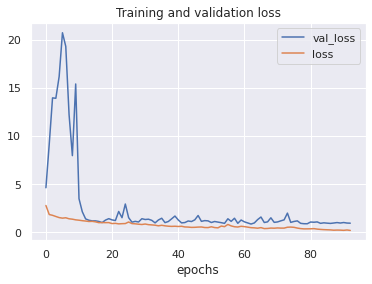

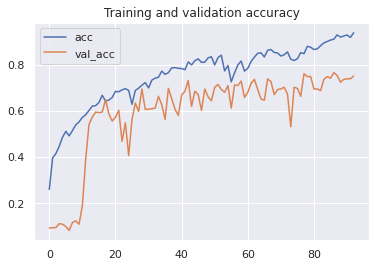

In [39]:
plt.title('Training and validation loss')
plt.xlabel('epochs')

plt.plot(hist['val_loss'])
plt.plot(hist['loss'])
plt.legend(['val_loss', 'loss'])

plt.figure()

plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('Training and validation accuracy')

plt.show()

In [40]:
model.load_weights('best_cvision.h5')

In [41]:
result = model.predict(test_generator, verbose=True)

640/640 [==============================] - 4s 5ms/step


### 6. Cross Validation (교차 검증)

In [44]:
# cross validation
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

result = 0
for train_index, valid_index in skf.split(train2,train['digit']) :
    
  mc = ModelCheckpoint('best_cvision.h5',save_best_only=True, verbose=1)
  
  x_train = train2[train_index]
  x_valid = train2[valid_index]    
  y_train = train['digit'][train_index]
  y_valid = train['digit'][valid_index]
  
  train_generator = idg.flow(x_train,y_train)
  valid_generator = idg2.flow(x_valid,y_valid)
  test_generator = idg2.flow(test2,shuffle=False)
  
  model = Sequential()

  model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))

  model.add(Flatten())

  model.add(Dense(1000,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(10,activation='softmax'))
  
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['acc'])
  
  learning_history = model.fit(train_generator,epochs=100, validation_data=valid_generator, callbacks=[es,mc,reLR])
  
  # predict
  model.load_weights('best_cvision.h5')
  result += model.predict(test_generator,verbose=True)/5

Epoch 1/100
52/52 [==============================] - ETA: 0s - loss: 2.7752 - acc: 0.2717
Epoch 1: val_loss improved from inf to 6.20884, saving model to best_cvision.h5
52/52 [==============================] - 4s 35ms/step - loss: 2.7752 - acc: 0.2717 - val_loss: 6.2088 - val_acc: 0.0659 - lr: 0.0010
Epoch 2/100
52/52 [==============================] - ETA: 0s - loss: 2.0413 - acc: 0.3590
Epoch 2: val_loss did not improve from 6.20884
52/52 [==============================] - 1s 21ms/step - loss: 2.0413 - acc: 0.3590 - val_loss: 14.7728 - val_acc: 0.1122 - lr: 0.0010
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 1.8425 - acc: 0.4011
Epoch 3: val_loss did not improve from 6.20884
52/52 [==============================] - 1s 22ms/step - loss: 1.8425 - acc: 0.4011 - val_loss: 19.4039 - val_acc: 0.1000 - lr: 0.0010
Epoch 4/100
52/52 [==============================] - ETA: 0s - loss: 1.7420 - acc: 0.4335
Epoch 4: val_loss did not improve from 6.20884
52/52 [===========

In [45]:
sub['digit'] = result.argmax(1)

In [46]:
sub.to_csv('nsh.csv', index=False)